# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:
-	Для оценки качества моделей применяйте метрику RMSE.
-	Значение метрики RMSE должно быть меньше 2500.
-	Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
-	Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
-	Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
-	Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

hewlt packard proboo elitbook
lenovo thinkpad

__Описание данных__

__Признаки__
-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	NotRepaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

__Целевой признак:__
Price — цена (евро)


## Подготовка данных

In [42]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder

<b>Откроем файл и изучим его<b/>

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [3]:
display(df.info())
display(df.head(5))
display('Количество явных дубликтов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'Количество явных дубликтов:'

4

Итого у нас есть 6 категориальных признаков и 11 числовых. Перед обучением мы кактегориальные признаки стандартизируем, а пока надо разобраться с дубликатами и пустыми значениями. Причем замечу у 5 категориальных признаков есть пустоты. Средним или медианным значением их не заменишь(

Для начала удалим явные дубликаты

In [4]:
df.drop_duplicates()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Значения в столбце VehicleType пустые значения заменим на unknowhn

In [6]:
df['VehicleType'] = df['VehicleType'].fillna('Unknown')

In [7]:
df['Gearbox'] = df['Gearbox'].fillna('Unknown')

Model. Чем заполнить их я не представляю возможным (по крайней мере как это сделать автоматизировано). 
Поэтому для всех пустых значений установим 'unknown'.

In [8]:
df['Model'] = df['Model'].fillna('Unknown')

In [9]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Чем заполнить значения по полю fueltype я не придумал, поэтому удалим их.

In [10]:
df = df.dropna(subset=['FuelType'])

NotRepaired.  Будем считаь если знаение  NaN  то в ремонте машина не была, поэтому пустым значениям установим значение 'yes'.

In [11]:
df['NotRepaired'] = df['NotRepaired'].fillna('yes')

In [12]:
df['NotRepaired'] .unique()

array(['yes', 'no'], dtype=object)

подробнее изучим категориальные переменные.

<AxesSubplot:>

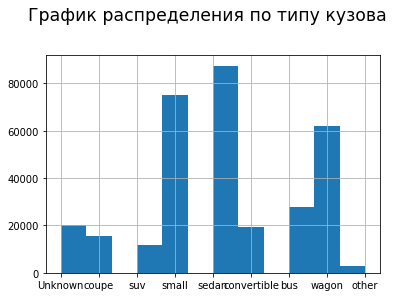

In [13]:
plt.suptitle('График распределения по типу кузова', x=0.5, y=1.05, ha='center', fontsize='xx-large')
df['VehicleType'].hist(bins=12)

<AxesSubplot:>

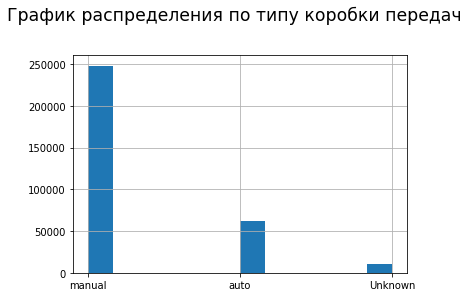

In [14]:
plt.suptitle('График распределения по типу коробки передач', x=0.5, y=1.05, ha='center', fontsize='xx-large')
df['Gearbox'].hist(bins=12)

<AxesSubplot:>

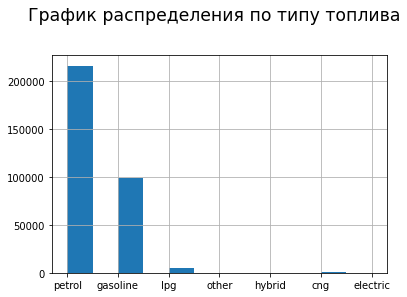

In [15]:
plt.suptitle('График распределения по типу топлива', x=0.5, y=1.05, ha='center', fontsize='xx-large')
df['FuelType'].hist(bins=12)

<AxesSubplot:>

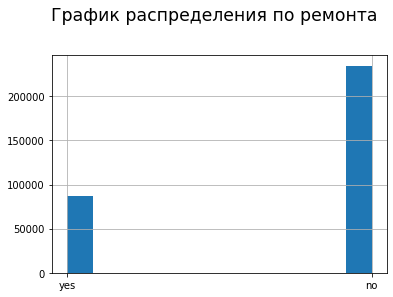

In [16]:
plt.suptitle('График распределения по ремонта', x=0.5, y=1.05, ha='center', fontsize='xx-large')
df['NotRepaired'].hist(bins=12)

Посмотрим на корелляции в признаках

<AxesSubplot:>

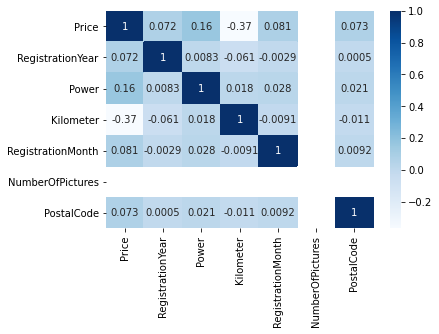

In [17]:
sns.heatmap (df.corr(), cmap='Blues', annot=True)

Мультиколлениарность между признаками не наблюдается и вообще корреляция по признакам очень слабая.
Наибольшая корелляция у цены с мощностью, со всеми остальными связь либо низкая либо отрицательная как, например, у пробега.

Также т.к. один из показателей которых нужно проанализировать  - это скорость работы, то имеет смысл категориальные переменные с двумя значениями перевести в булевый тип. Из тех, что есть у нас - ~~это Gearbox (ручка/автомат) и~~ NotRepaired(да/нет)

In [18]:
df['NotRepaired'] = df['NotRepaired'].replace("yes", "1")
df['NotRepaired'] = df['NotRepaired'].replace("no", "0")
df['NotRepaired']=df['NotRepaired'].astype(int) 
df['NotRepaired']=df['NotRepaired'].astype(bool) 

Посмотрим есть ли в данных выбросы. Т.к. самая высокая корелляция у power, то и выбросы мы будем смотреть по ней.

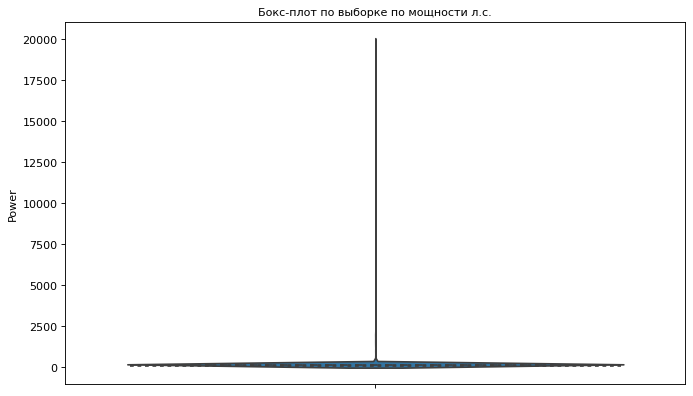

In [19]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Power', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по выборке по мощности л.с.', fontsize=10)
plt.show()

Очень много неправдоподобных значений. Так как этот признак больше остальных коррелирует с целевым, то надо его предобратотать.
Удалим выбросы. Под выбросом я понимаю всё значения за пределами 25% перцентили минус 1.5 х МКР и 75% перцентили плюс 1.5 х МКР 

In [20]:
Q1 =  df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1
df[df['Power'] < 1]['Power'].count()

df = df.drop(df[df['Power'] < Q1-1.5*IQR].index)
df = df.drop(df[df['Power'] > Q3+1.5*IQR].index)

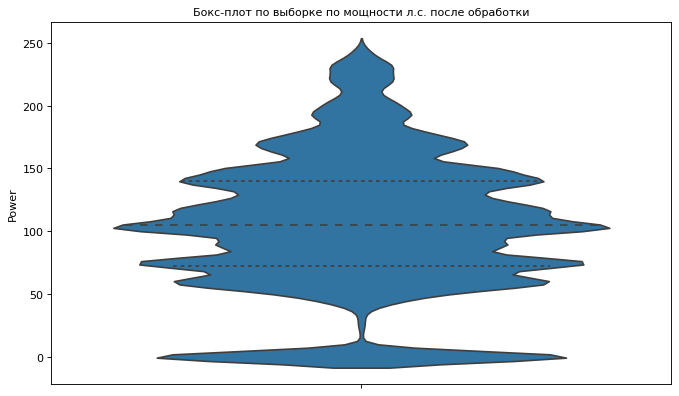

In [21]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Power', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по выборке по мощности л.с. после обработки', fontsize=10)
plt.show()

Визуально стало вроде бы лучше. Но смущает машины с нулевой мощностью лошадиных сил, такого не бывает. Уберем их из выборки.

In [22]:
df = df.drop(df[df['Power'] == 0].index)

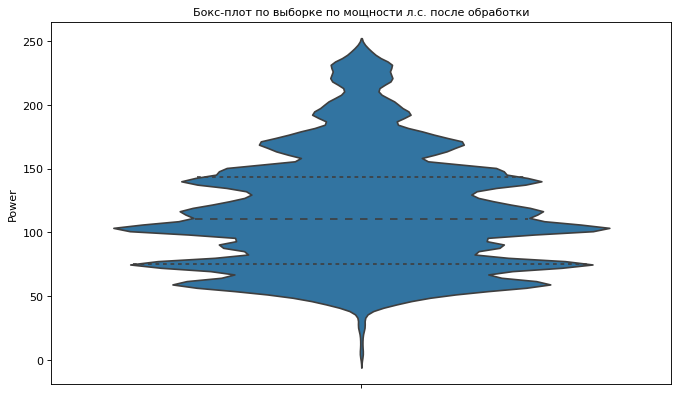

In [23]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Power', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по выборке по мощности л.с. после обработки', fontsize=10)
plt.show()

<div class="alert alert-block alert-info">
<b>Посмотрим на корелляцию в признаках после работы с аномалиями</b> 
</div>

<AxesSubplot:>

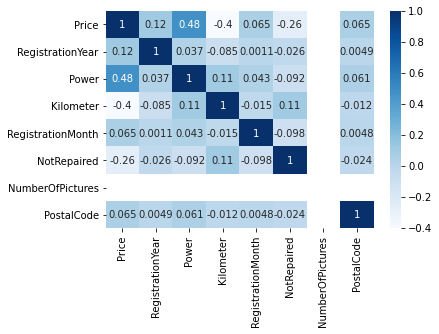

In [24]:
sns.heatmap (df.corr(), cmap='Blues', annot=True)


<b>Как видим мощность стала самым важным признаком влияющим на цену, также сильно (в + или -) влияет Год регистрации и факт ремонта</b> 
По факту ремонта не представляю возможным как надо выявить аномалии, а вот по году регистрации вполне. Поступим также как и с мощностью.


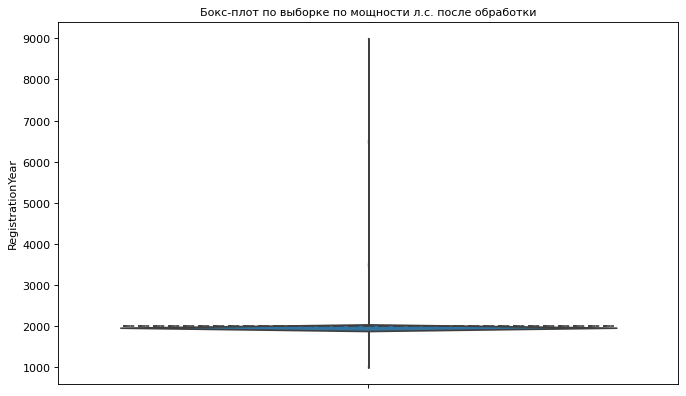

In [26]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='RegistrationYear', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по выборке по мощности л.с. после обработки', fontsize=10)
plt.show()

In [27]:
Q1 =  df['RegistrationYear'].quantile(0.25)
Q3 = df['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1
df[df['RegistrationYear'] < 1]['RegistrationYear'].count()

df = df.drop(df[df['RegistrationYear'] < Q1-1.5*IQR].index)
df = df.drop(df[df['RegistrationYear'] > Q3+1.5*IQR].index)

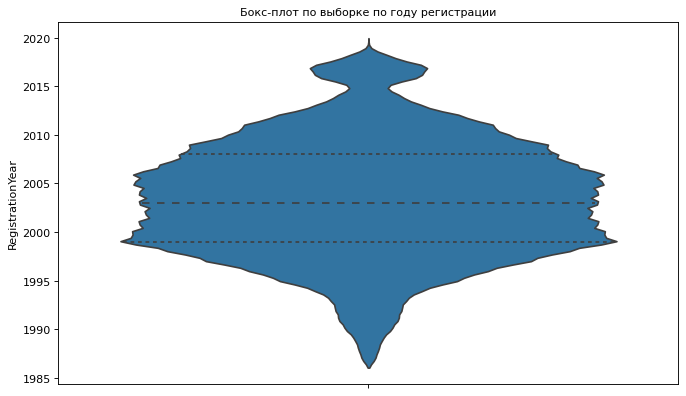

In [31]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='RegistrationYear', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по выборке по году регистрации', fontsize=10)
plt.show()


<b>Распределение стало определенно лучше</b> 


<AxesSubplot:>

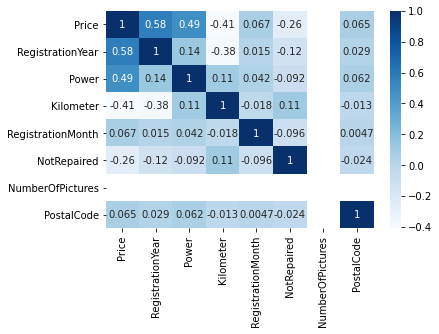

In [29]:
sns.heatmap (df.corr(), cmap='Blues', annot=True)


<b>Теперь посмотрим на наличие аномалий в километраже</b> 


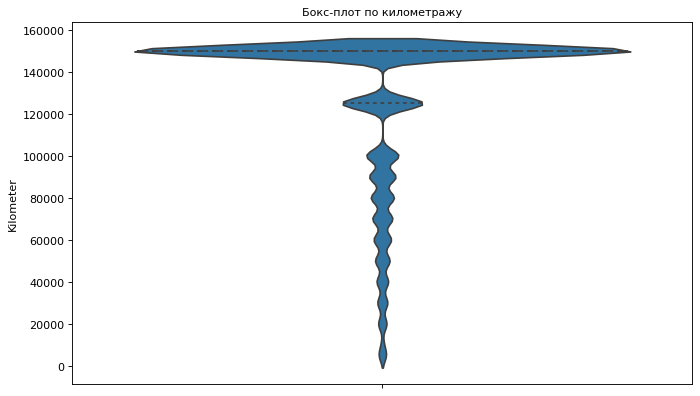

In [30]:
# Import Data

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Kilometer', data=df, scale='width', inner='quartile', grid=True)
#sns.violinplot(x='all', y='rougher.input.feed_size', data=df_test, scale='width', inner='quartile')

# Decoration
plt.title('Бокс-плот по километражу', fontsize=10)
plt.show()

Последним шагом я удалю поля которые как мне кажется для модели будут лишними, это все поля с датой - 'DateCrawled', 'DateCreated', 'LastSeen'


<b>Также уберем ненужные маловлияющие признаки - PostalCode,RegistrationMonth  </b> 


In [36]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen','PostalCode', 'RegistrationMonth'], axis=1)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280899 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             280899 non-null  int64 
 1   VehicleType       280899 non-null  object
 2   RegistrationYear  280899 non-null  int64 
 3   Gearbox           280899 non-null  object
 4   Power             280899 non-null  int64 
 5   Model             280899 non-null  object
 6   Kilometer         280899 non-null  int64 
 7   FuelType          280899 non-null  object
 8   Brand             280899 non-null  object
 9   NotRepaired       280899 non-null  bool  
 10  NumberOfPictures  280899 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 23.8+ MB


### Краткий вывод по первому шагу.

- мы удалили ненужные явные дубликаты;
- заполнили пропуски в данных наиболее подходящими значениями;
- поменяли в некоторых столбцах тип данных;
- посмотрели на общее распределение по данным;
- посмотрев на корреляцию в данных выявили признаки наиболее кореллирующие с целевым признаком и по нему предобработали выбросы
- на последнем шаге мы избаивились от ненужных столбцов.

Короче говоря, мы сделали всё от нас зависящее для того чтобы мы могли переходить к обучению модели.

In [38]:


display(df.isna().sum())
df.describe()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
NumberOfPictures    0
dtype: int64

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,280899.000000,280899.000000,280899.000000,280899.000000,280899.0
mean,4667.334270,2003.467456,116.391222,128391.201108,0.0
std,4487.421818,5.919482,45.030427,36608.086597,0.0
min,0.000000,1987.000000,1.000000,5000.000000,0.0
25%,1299.000000,1999.000000,75.000000,125000.000000,0.0
50%,3000.000000,2003.000000,110.000000,150000.000000,0.0
75%,6790.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,2019.000000,245.000000,150000.000000,0.0


## Обучение моделей

In [39]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

### Разобъем  на выборки (обучающая, тестовая, валидная)

In [43]:
target = df['Price']
features = df.drop('Price', axis=1)

Закодируем категориальные признаки, чтобы не попасть в дамми-ловушку, применим аргумент drop_first функции pd.get_dummies()

In [44]:
#OHE кодирование
ohe_features = pd.get_dummies(features, drop_first=True)

In [53]:
#ordinal кодирование
coder = OrdinalEncoder()
all_columns = ['VehicleType','Gearbox','FuelType','Brand','Model']
new_features = features[all_columns]
new_features = pd.DataFrame(coder.fit_transform(new_features),
                                columns=new_features.columns, 
                                index=new_features.index)
ordinal_features = features.copy()
for column in all_columns:
    ordinal_features[column] = new_features[column]


<b>Обучющих и тестовых выборок у нас будет  2 для ohe и ordinal</b> 


In [61]:
features_train, features_inter, target_train, target_inter = train_test_split(
    features.copy(), 
    target.copy(), 
    test_size=0.4, 
    random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_inter.copy(),
    target_inter.copy(),
    test_size=0.5,
    random_state=42)

In [62]:
ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]
ordinal_features_valid = ordinal_features.loc[features_valid.index, :]


ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]
ohe_features_valid = ohe_features.loc[features_valid.index, :]

Тренировочные выборки у нас с такой размерностью

In [63]:
ordinal_features_train.shape

(168539, 10)

In [64]:
ohe_features_train.shape

(168539, 307)

Тестовые и валидныетакие:

In [65]:
ordinal_features_test.shape

(56180, 10)

In [66]:
ohe_features_test.shape

(56180, 307)

### Масштабирование
Стандартизируем численные признаки при помощи StandardScaler

In [67]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168539 entries, 241814 to 153950
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       168539 non-null  object
 1   RegistrationYear  168539 non-null  int64 
 2   Gearbox           168539 non-null  object
 3   Power             168539 non-null  int64 
 4   Model             168539 non-null  object
 5   Kilometer         168539 non-null  int64 
 6   FuelType          168539 non-null  object
 7   Brand             168539 non-null  object
 8   NotRepaired       168539 non-null  bool  
 9   NumberOfPictures  168539 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 13.0+ MB


In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(ohe_features_train)
X_valid = scaler.transform(ohe_features_valid)
X_test = scaler.transform(ohe_features_test)

In [69]:
y_train = target_train
y_test = target_test
y_valid = target_valid

Перед нами стоит задача регресии. 
Мы будем использовать следующие модели:


* линейная регрессия;
* дерево решений;
* LGBMRegressor;
* CatBoostRegressor.

<b>
Попробуем использовать GreedSeacrhCV 
</b> 

In [70]:
%%time
state = 42
cv = KFold()
model = DecisionTreeRegressor(random_state=state)
    

param_dict = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

griddtr = GridSearchCV(model, param_dict, cv = cv, scoring=rmse_score, n_jobs = -1)

griddtr.fit(ordinal_features_train, target_train)
griddtr.best_score_

CPU times: user 2min 37s, sys: 6.21 s, total: 2min 44s
Wall time: 2min 44s


-2189.9992905786594

In [71]:
print(griddtr.best_estimator_)
print()
print(griddtr.best_params_)
print()
print(griddtr.best_score_)

DecisionTreeRegressor(max_depth=7, max_features=6, min_samples_leaf=3,
                      random_state=42)

{'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 3}

-2189.9992905786594


In [72]:
%%time
state = 42
cv = KFold()
model = LinearRegression()
    

param_dict = {'fit_intercept':[True, False],
                    'copy_X':[True, False]}

griddlr = GridSearchCV(model, param_dict, cv = cv, scoring=rmse_score, n_jobs = -1)
griddlr.fit(X_train, y_train)
griddlr.best_score_

CPU times: user 3min 14s, sys: 1min 13s, total: 4min 27s
Wall time: 4min 29s


-71754475184378.23

In [73]:
print(griddlr.best_estimator_)
print()
print(griddlr.best_params_)
print()
print(griddlr.best_score_)

LinearRegression()

{'copy_X': True, 'fit_intercept': True}

-71754475184378.23


In [74]:
model = CatBoostRegressor() 
param_dict = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[42],
                'verbose':[False]}]

print()
gridcb = GridSearchCV(model, param_dict, scoring=rmse_score,n_jobs = -1)
gridcb.fit(ordinal_features_train, target_train)
gridcb.best_score_

-1560.6052998499383

In [75]:
%%time
print(gridcb.best_estimator_)
print()
print(gridcb.best_params_)
print()
print(gridcb.best_score_)


{'learning_rate': 0.5, 'random_state': 42, 'verbose': False}

-1560.6052998499383
CPU times: user 555 µs, sys: 72 µs, total: 627 µs
Wall time: 386 µs


In [76]:
model = LGBMRegressor() 
param_dict = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]}]
print()
gridlgmr = GridSearchCV(model, param_dict, scoring=rmse_score,n_jobs = -1)
gridlgmr.fit(ordinal_features_train, target_train)
gridlgmr.best_score_

-1552.063363738204

In [77]:
%%time
print(gridlgmr.best_estimator_)
print()
print(gridlgmr.best_params_)
print()
print(gridlgmr.best_score_)

LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=42)

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 42}

-1552.063363738204
CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.12 ms


### Обучим модели

In [80]:
model1 = DecisionTreeRegressor(random_state=42,
                               max_depth =7, 
                               max_features=6,
                               min_samples_leaf=3) 
start = time.time()
model1.fit(ordinal_features_train, target_train) 
fit_time = time.time() - start
predictions_1 = model1.predict(ordinal_features_valid) # получим предсказания модели
pred_time = time.time() - start
result1 = rmse(target_valid,predictions_1)


print('DecisionTreeRegressor: ', result1)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

DecisionTreeRegressor:  2185.0461609860286
Время обучения:  0.2745940685272217
Время предсказания:  0.31444787979125977


In [82]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(X_train, y_train) 
fit_time = time.time() - start
predictions_2 = model2.predict(X_valid) # получим предсказания модели
pred_time = time.time() - start
result2 = rmse(y_valid,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LinearRegression:  2330.0042318722344
Время обучения:  19.131540298461914
Время предсказания:  19.23752236366272


In [83]:
model3 = CatBoostRegressor(learning_rate = 0.5,
                           random_state = 42,
                           verbose = False) 
start = time.time()
model3.fit(ordinal_features_train, target_train) 
fit_time = time.time() - start
predictions_3 = model3.predict(ordinal_features_valid) # получим предсказания модели
pred_time = time.time() - start
result3 = rmse(target_valid,predictions_3)


print("CatBoostRegressor", result4)

CatBoostRegressor:  1563.3624893685096
Время обучения:  25.938984632492065
Время предсказания:  26.012470960617065


In [84]:
model4 = LGBMRegressor(learning_rate = 0.3,
                       num_leaves = 200,
                       random_state = 42) 
start = time.time()
model4.fit(ordinal_features_train, target_train) 
fit_time = time.time() - start
predictions_4 = model4.predict(ordinal_features_valid) # получим предсказания модели
pred_time = time.time() - start
result4 = rmse(target_valid,predictions_4)


print('LGBMRegressor: ', result4)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LGBMRegressor:  1552.7403365170971
Время обучения:  141.3521852493286
Время предсказания:  141.94370102882385


Значения вполне себе. Выберем <b>лучшую</b> модель.


<b>Составим сравнительную таблицу моделей</b> 
    

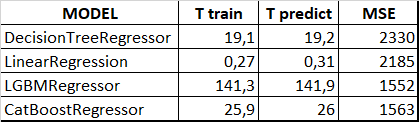





<b>Быстрее всего работает линейная регрессия, лучшая по показателю rmse LGBMRegressor, на этих двух моделях мы и протестируем наши тестовый данные</b> 


## Анализ моделей

### проверим модели на тесте


<b>Я объедининл валидную выборку с обучающей для того чтобы модель лучше обучилась.</b> 


In [90]:
features_train_all = pd.concat([ohe_features_train, ohe_features_valid])
target_train_all = pd.concat([target_train, target_valid])

In [91]:
%%time
model = LinearRegression(copy_X = True,
                          fit_intercept = True)


model.fit(features_train_all, target_train_all)
predicted = model.predict(X_test)
resultlrr = rmse(y_test,predicted)
print("LinearRegression", resultlrr)

LinearRegression 760655.587780045
CPU times: user 18.4 s, sys: 11.8 s, total: 30.2 s
Wall time: 30.2 s


In [104]:
features_train_all_2 = pd.concat([ordinal_features_train, ordinal_features_valid])

In [106]:
%%time
model5 = LGBMRegressor(learning_rate = 0.3,
                       num_leaves = 200,
                       random_state = 42) 

model5.fit(features_train_all_2, target_train_all)
#ValueError: Expected 2D array, got 1D array instead:
predicted_5 = model5.predict(ordinal_features_test)
resultlgmr = rmse(target_test,predicted_5)
print("LGBMRegressor", resultlgmr)

LGBMRegressor 1533.5670889201147
CPU times: user 11.9 s, sys: 0 ns, total: 11.9 s
Wall time: 11.9 s


## Итоговый вывод

- Мы выбрали 4 модели для тестирования (линейная регрессия, дерево решений, LGBMRegressor, CatBoostRegressor)
- Модели поделили на группы и для каждой закодировали признаки(ohe и ordinal)
- После чего обучили модели и проверили сколько по времени обучается модели, сколько она предсказывает и с каким показателем rmse
- На основании критериев - самая быстрая и самая точная, мы выбрали 2 модели - Линеную регрессию и LGBMRegressor
- Проверив на тестовой выборке эти две модели, мы выявили что скорость работы также осталось за линейной, но показатель rmse очень и очень плохой, в то время как LGBMRegressor показал отличный результат 1533.5, пускай и не с самым быстрой скоростью обучения и предсказания.
